In [1]:
#!pip install numpy
#!pip install sklearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import sklearn as skl
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import iqr, skew, kurtosis, median_abs_deviation, variation, hmean
from sklearn.model_selection import cross_val_score

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br> 
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

print(len(dates))

672


<div class=consignes> et les fichiers d'annotations:</div>

In [5]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


<div class=consignes> On compte sur vous, bonne chance ! </div>

## Data Visualisation

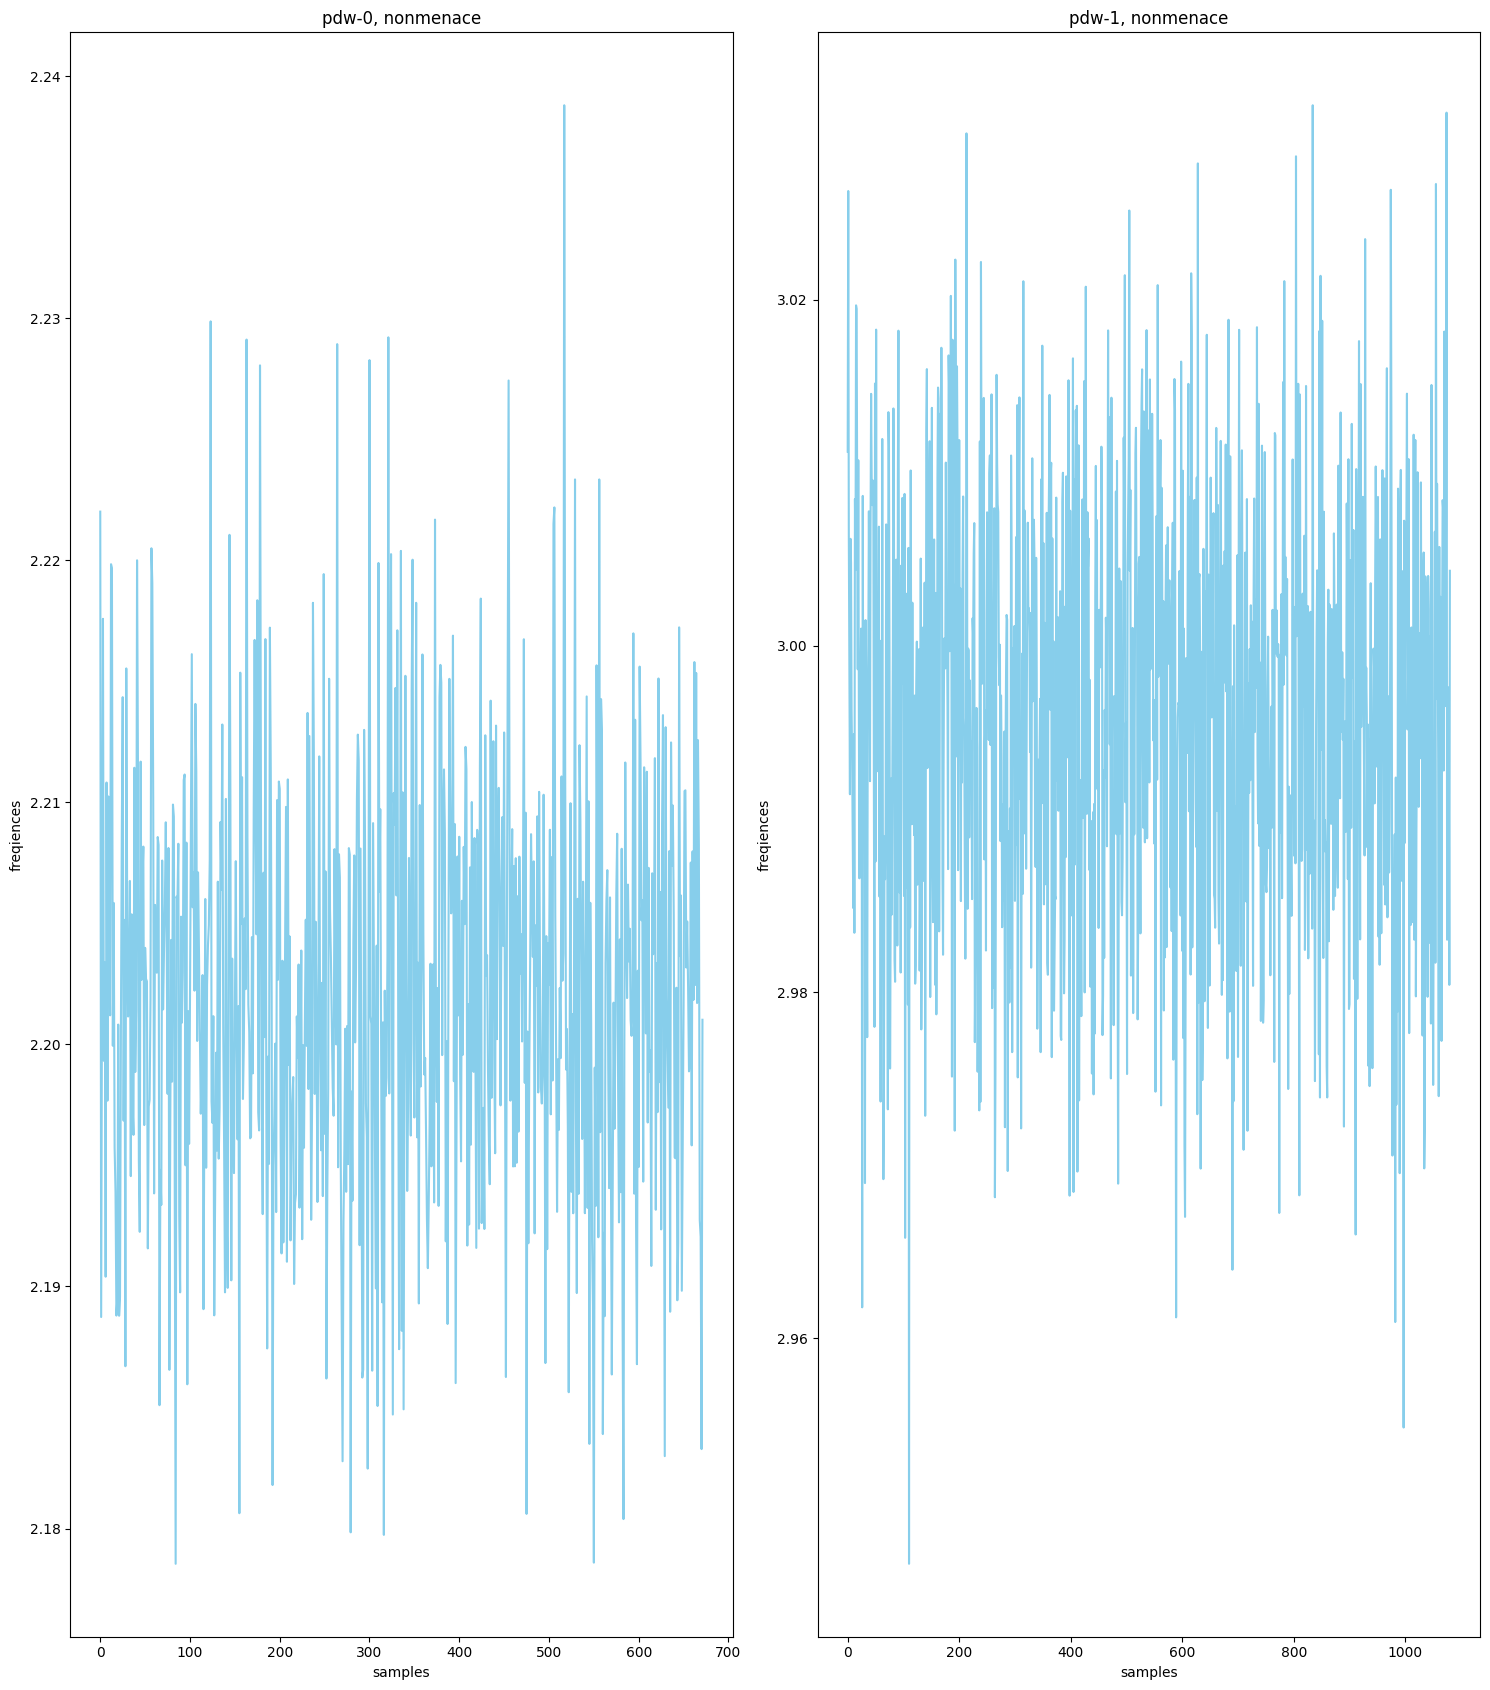

In [6]:
fig, ax= plt.subplots(1,2, figsize=(15, 17))
for i in range(2):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    frequences = pdws['frequence']
    r= i
    ax[r].plot(frequences, color='skyblue')
    ax[r].set_title(f'pdw-{i}, {label}')
    ax[r].set_xlabel('samples')
    ax[r].set_ylabel('freqiences')
plt.tight_layout()
plt.show()

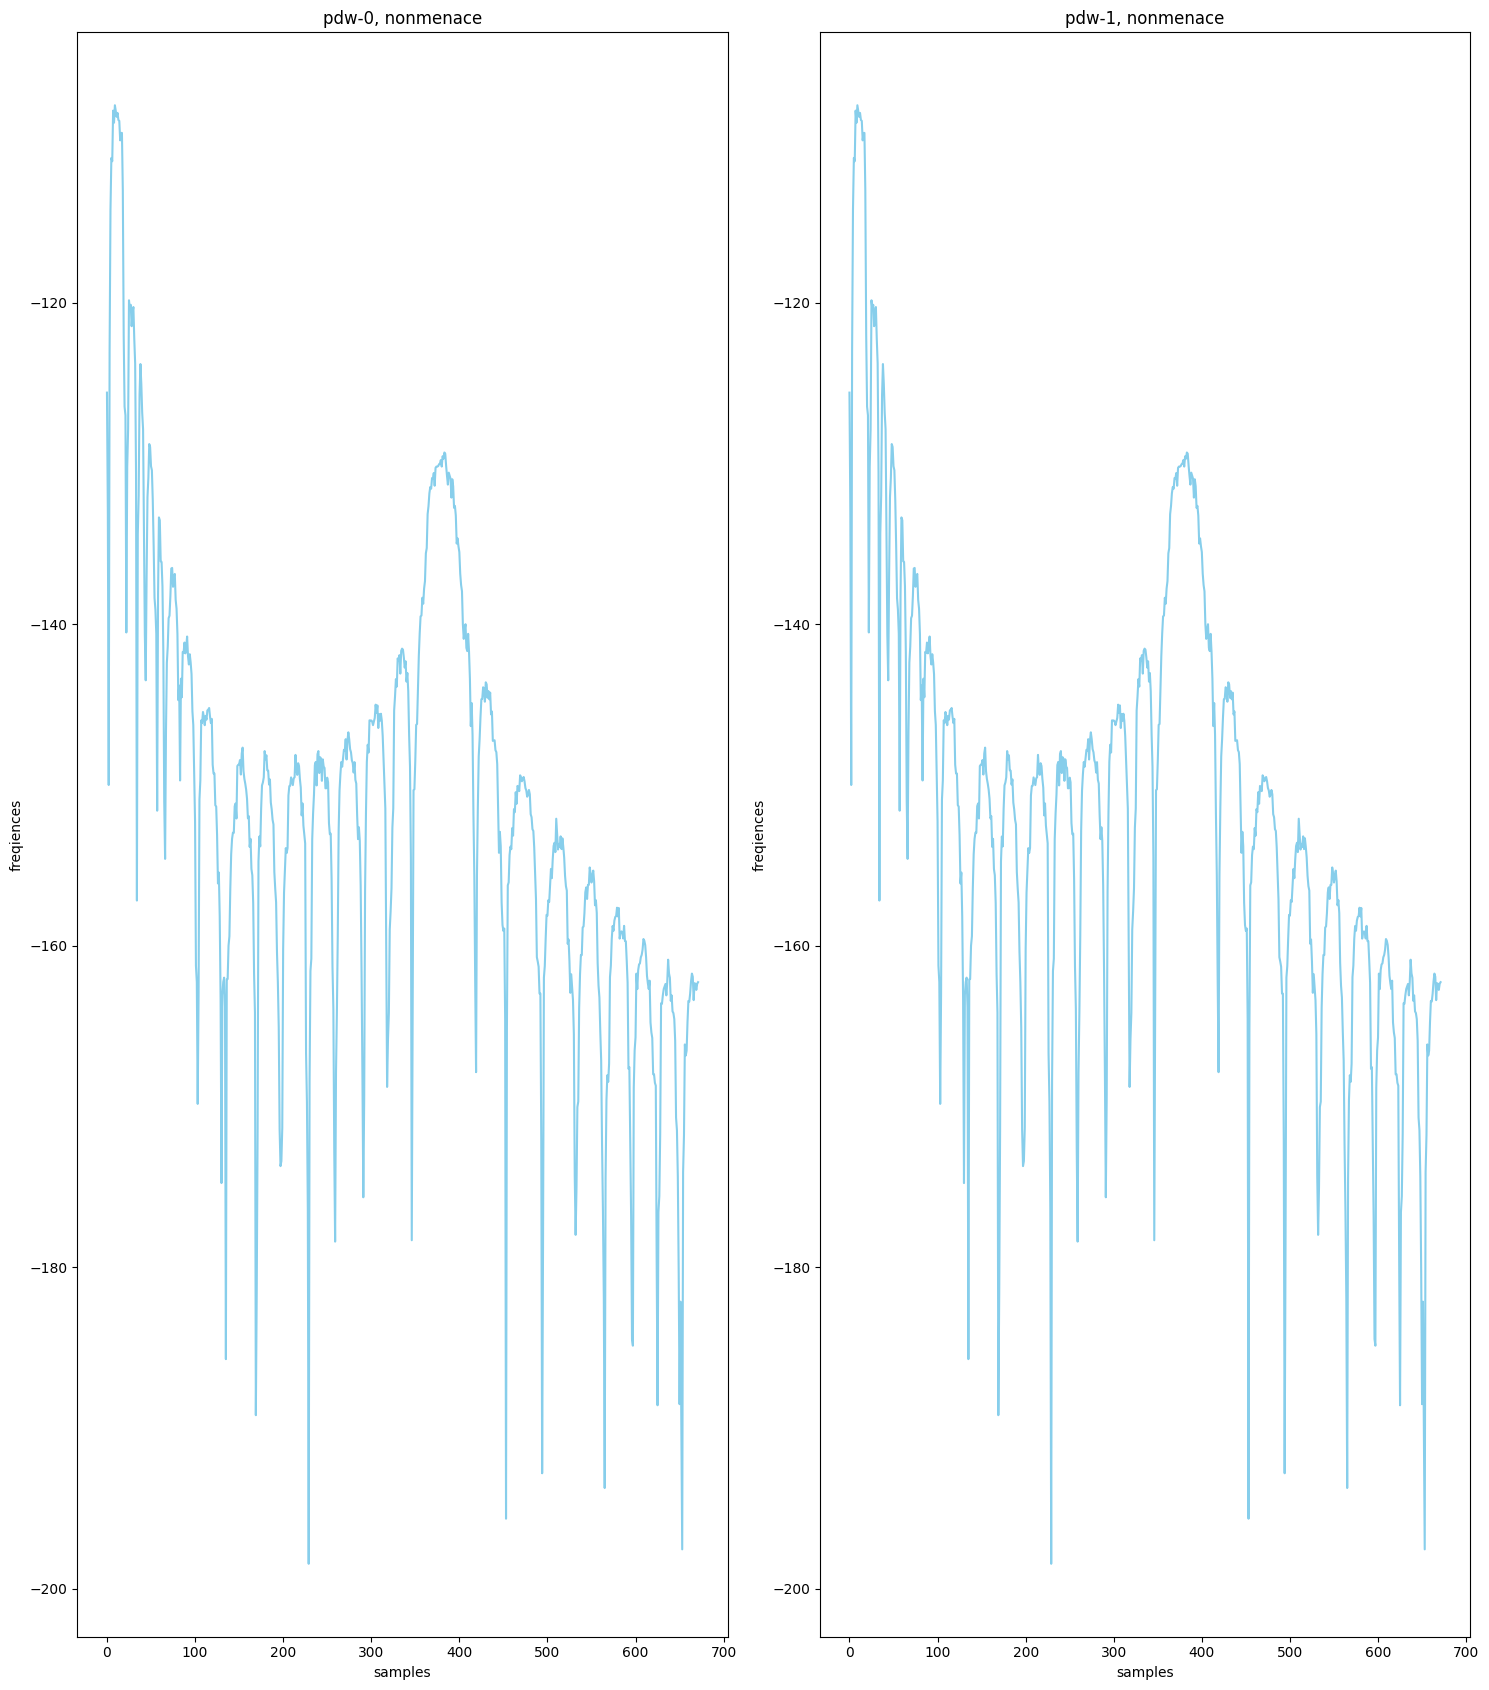

In [7]:
fig, ax= plt.subplots(1,2, figsize=(15, 17))
for i in range(2):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    puisaances = pdws['puissance']
    r= i
    ax[r].plot(puissances, color='skyblue')
    ax[r].set_title(f'pdw-{i}, {label}')
    ax[r].set_xlabel('samples')
    ax[r].set_ylabel('freqiences')
plt.tight_layout()
plt.show()

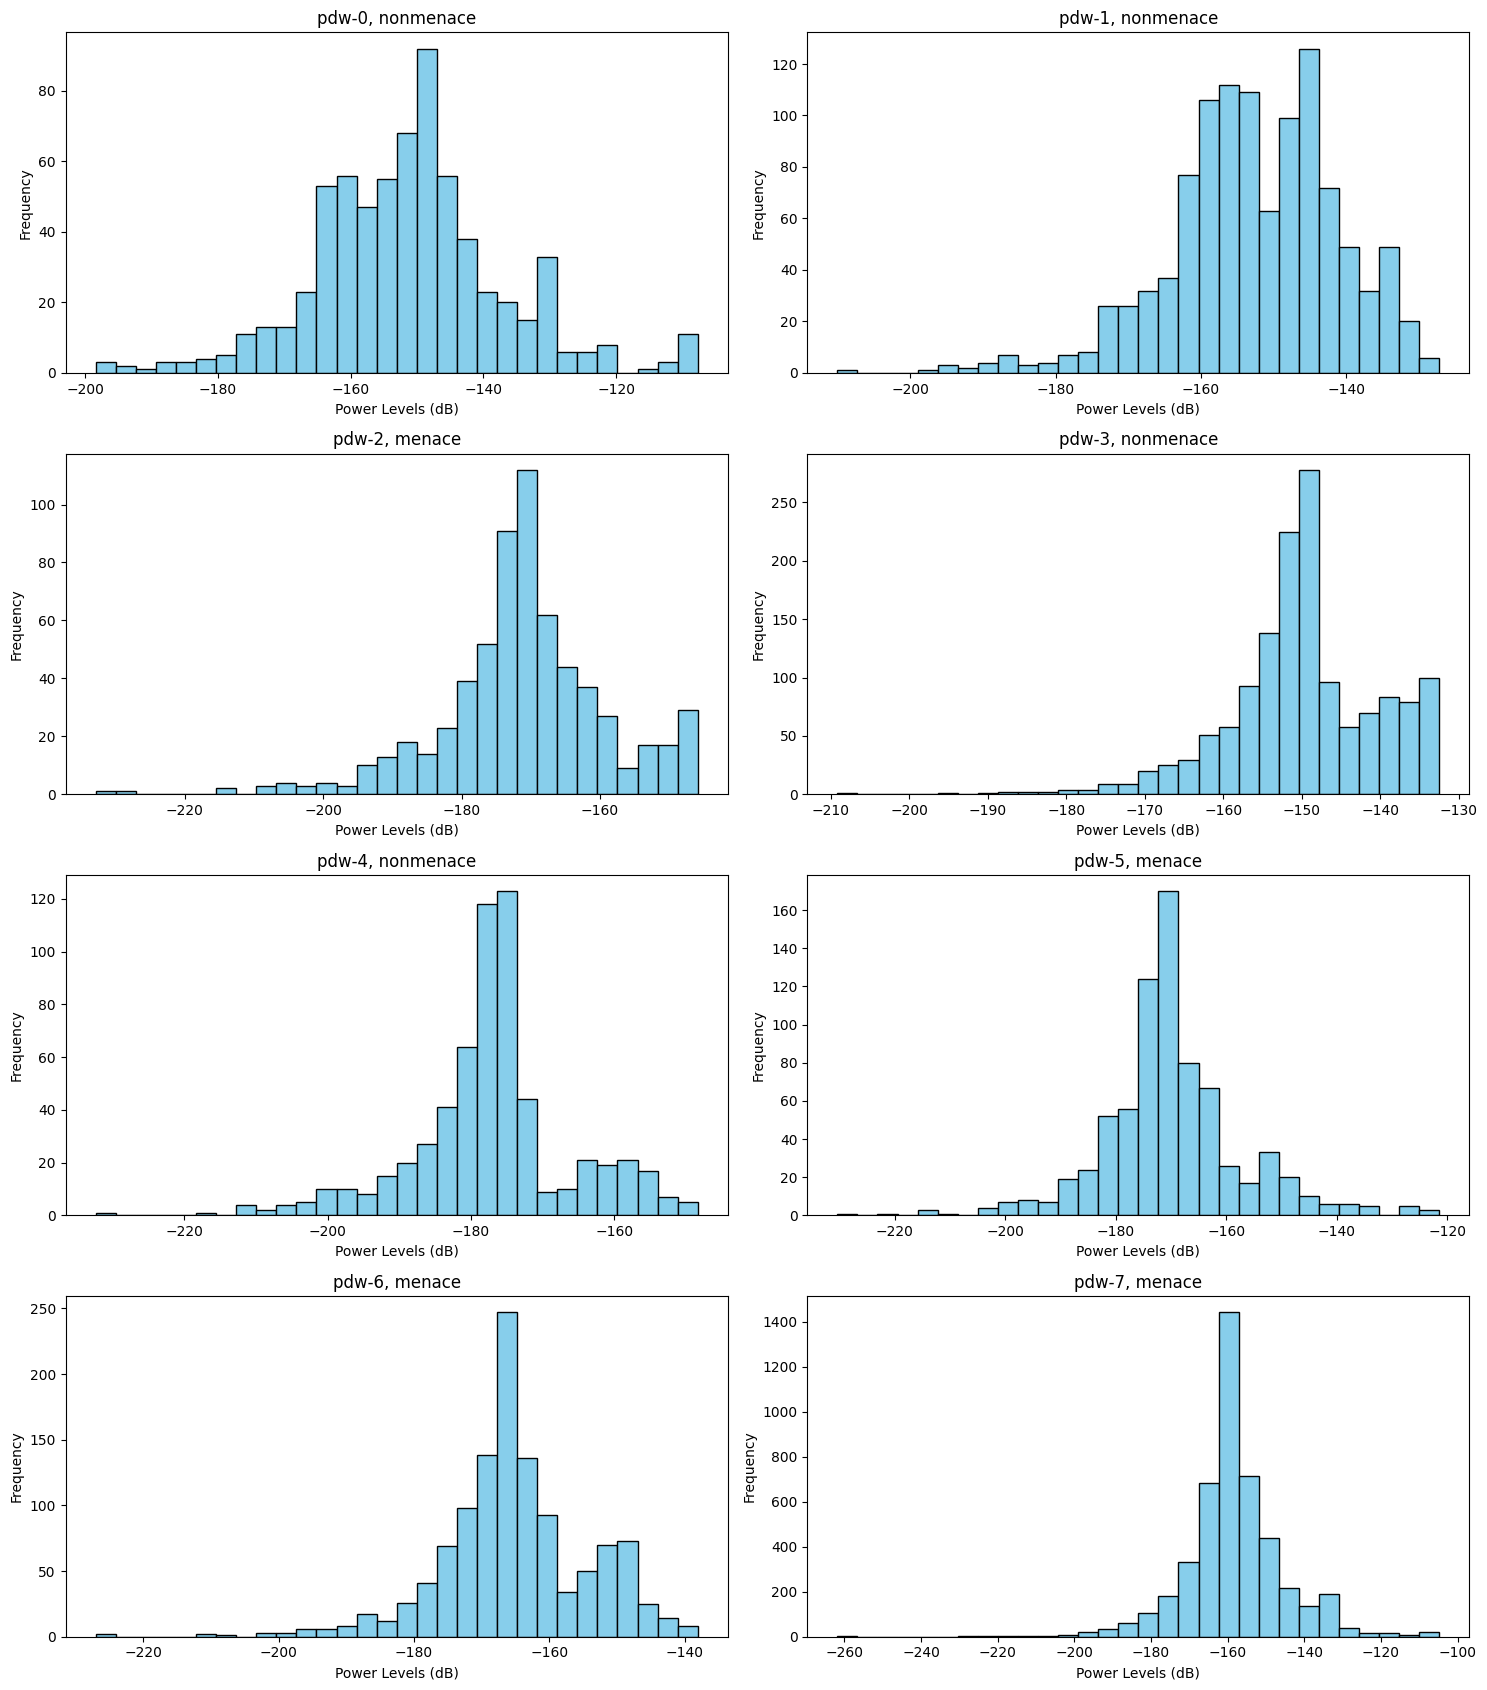

In [8]:
fig, ax= plt.subplots(4,2, figsize=(15, 17))
for i in range(8):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    puissances = pdws['puissance']
    r= i//2
    c= i%2
    ax[r,c].hist(puissances, bins=30, color='skyblue', edgecolor='black')
    ax[r,c].set_title(f'pdw-{i}, {label}')
    ax[r,c].set_xlabel('Power Levels (dB)')
    ax[r,c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


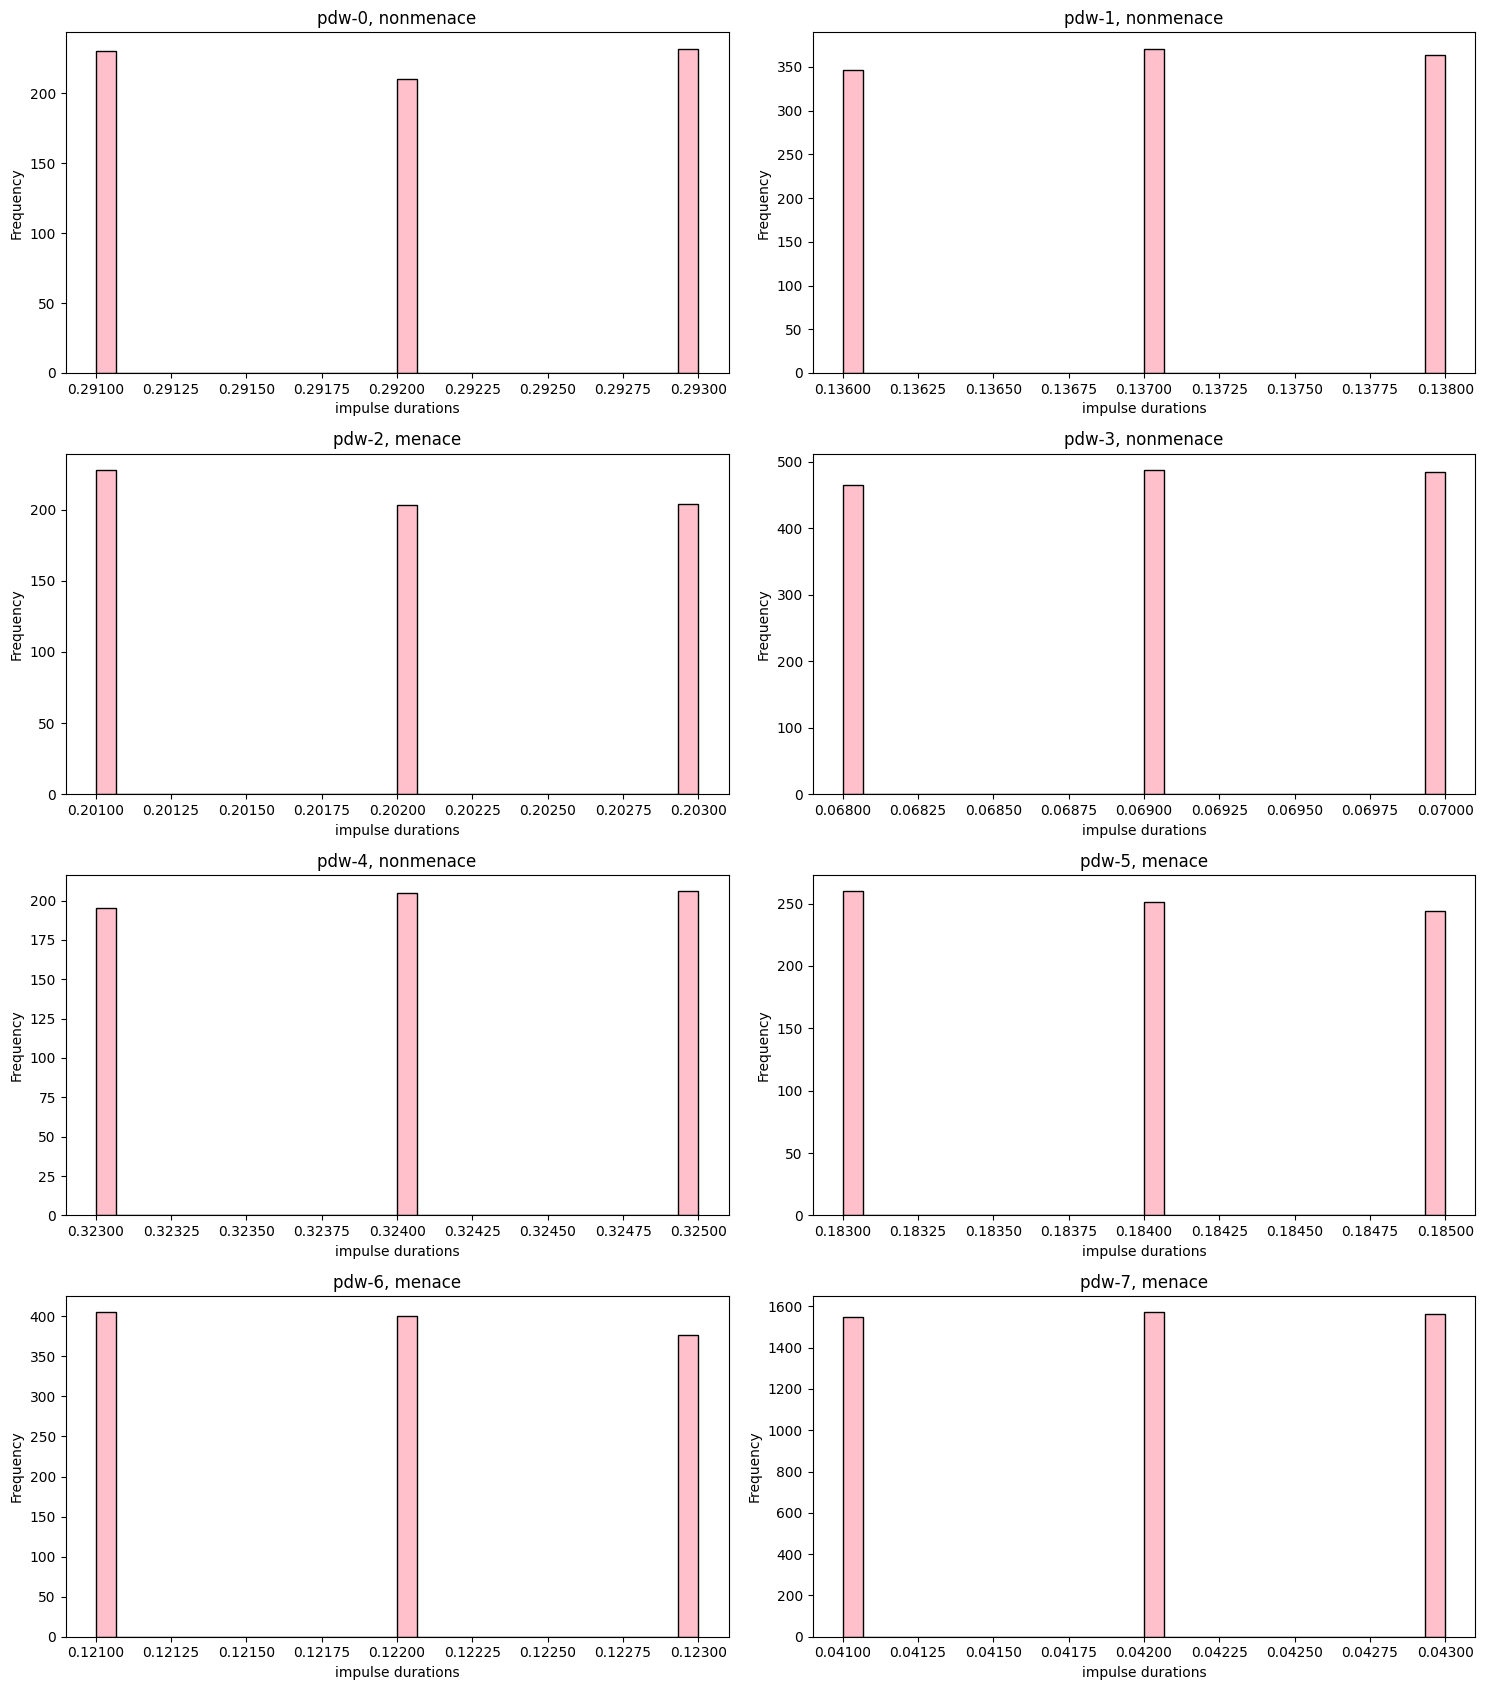

In [9]:
fig, ax= plt.subplots(4,2, figsize=(15, 17))
for i in range(8):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    largeurs = pdws['largeur']
    r= i//2
    c= i%2
    ax[r,c].hist(largeurs, bins=30, color='pink', edgecolor='black')
    ax[r,c].set_title(f'pdw-{i}, {label}')
    ax[r,c].set_xlabel('impulse durations')
    ax[r,c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

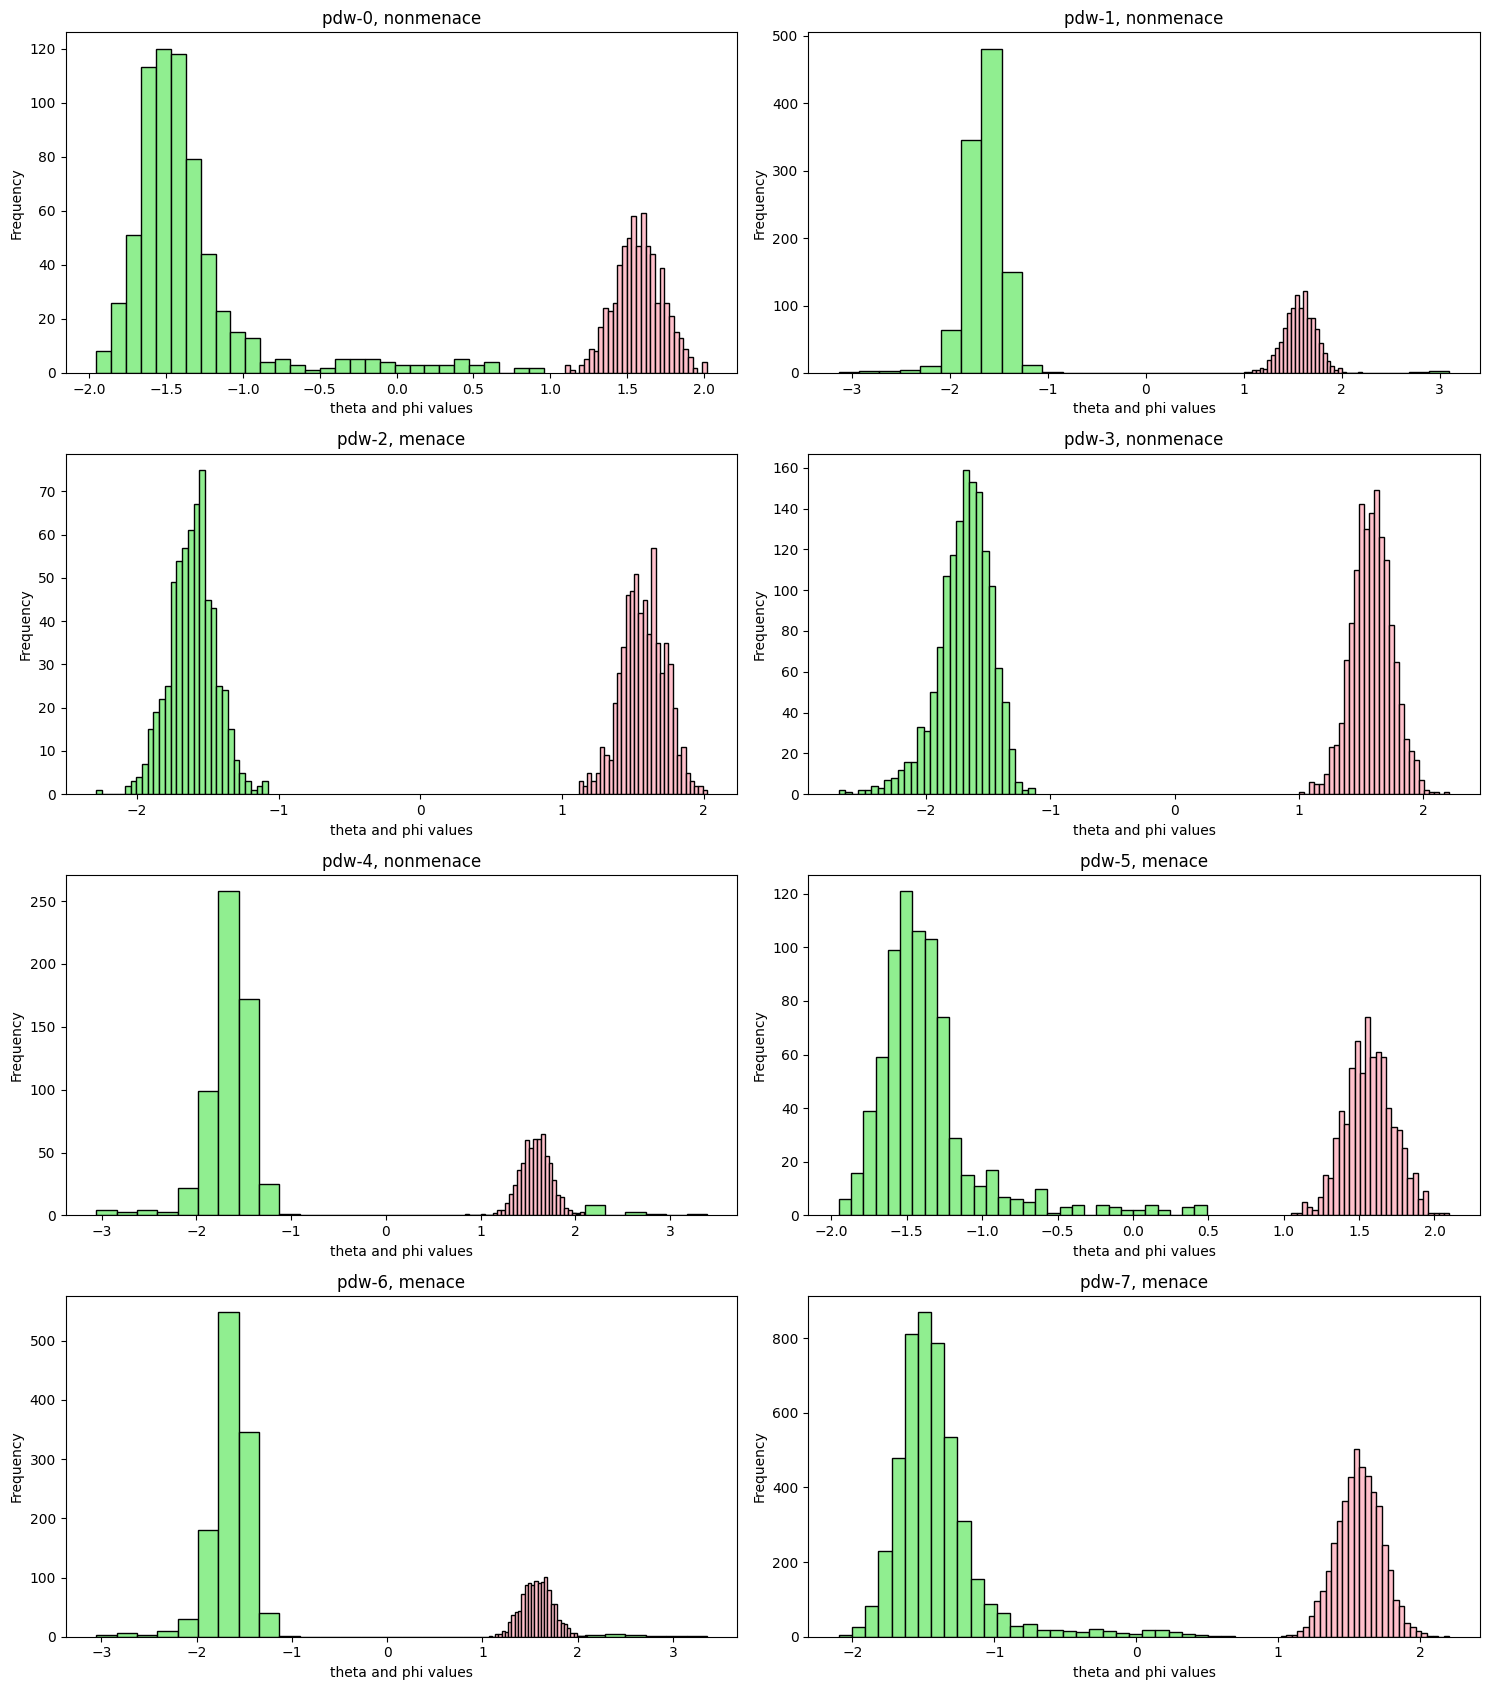

In [10]:
fig, ax= plt.subplots(4,2, figsize=(15, 17))
for i in range(8):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    theta = pdws['theta']
    phi = pdws['phi']
    r= i//2
    c= i%2
    ax[r,c].hist(theta, bins=30, color='lightgreen', edgecolor='black')
    ax[r,c].hist(phi, bins=30, color='pink', edgecolor='black')
    ax[r,c].set_title(f'pdw-{i}, {label}')
    ax[r,c].set_xlabel('theta and phi values')
    ax[r,c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

here we can see some differences in the amplitudes to explore later

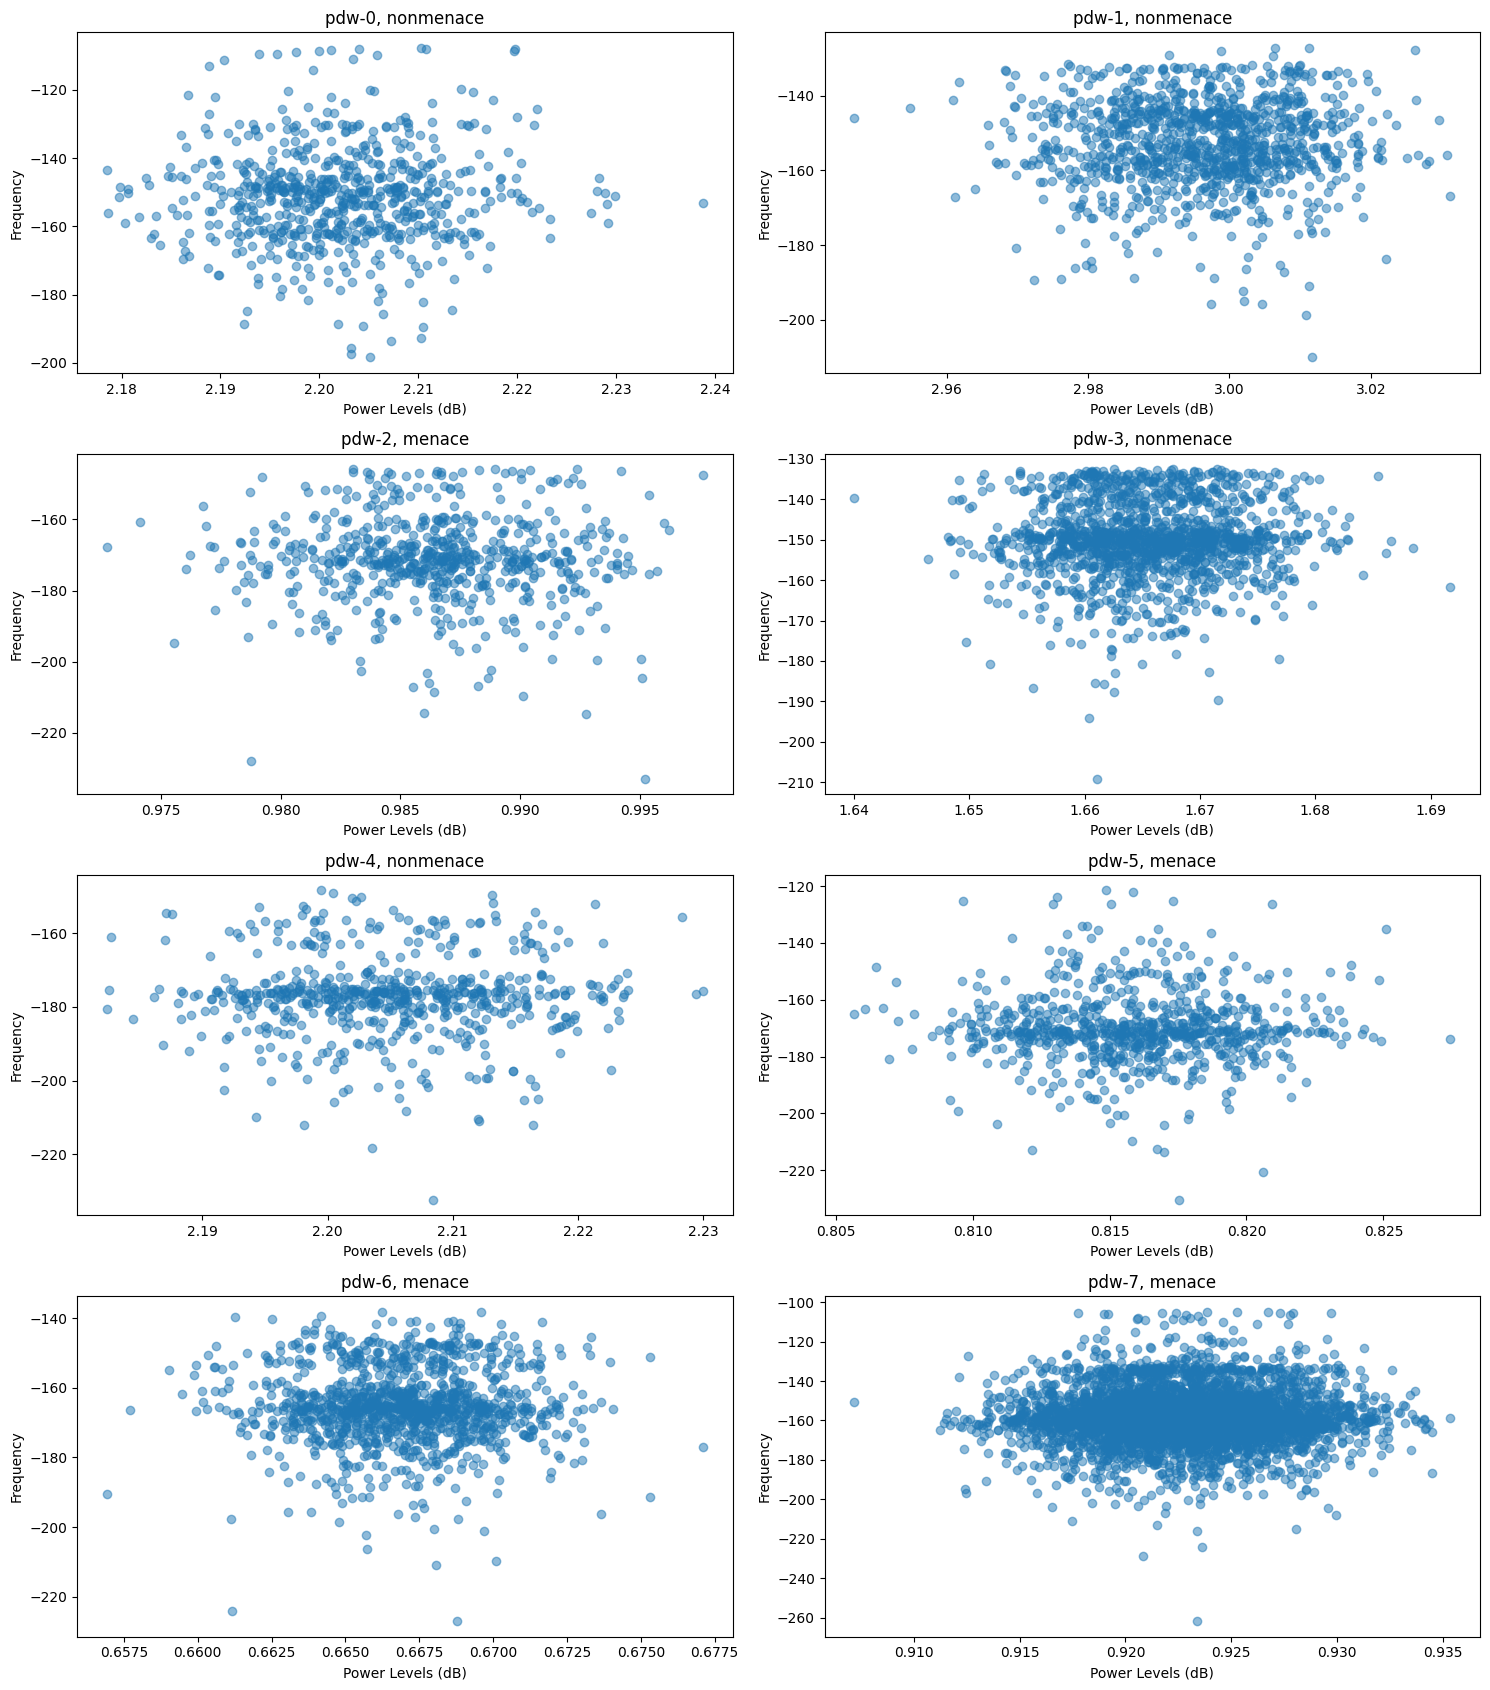

In [11]:
fig, ax= plt.subplots(4,2, figsize=(15, 17))
for i in range(8):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    puissances = pdws['puissance']
    frequences= pdws['frequence']
    r= i//2
    c= i%2
    ax[r,c].scatter(frequences, puissances,alpha=0.5)
    ax[r,c].set_title(f'pdw-{i}, {label}')
    ax[r,c].set_xlabel('Power Levels (dB)')
    ax[r,c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()



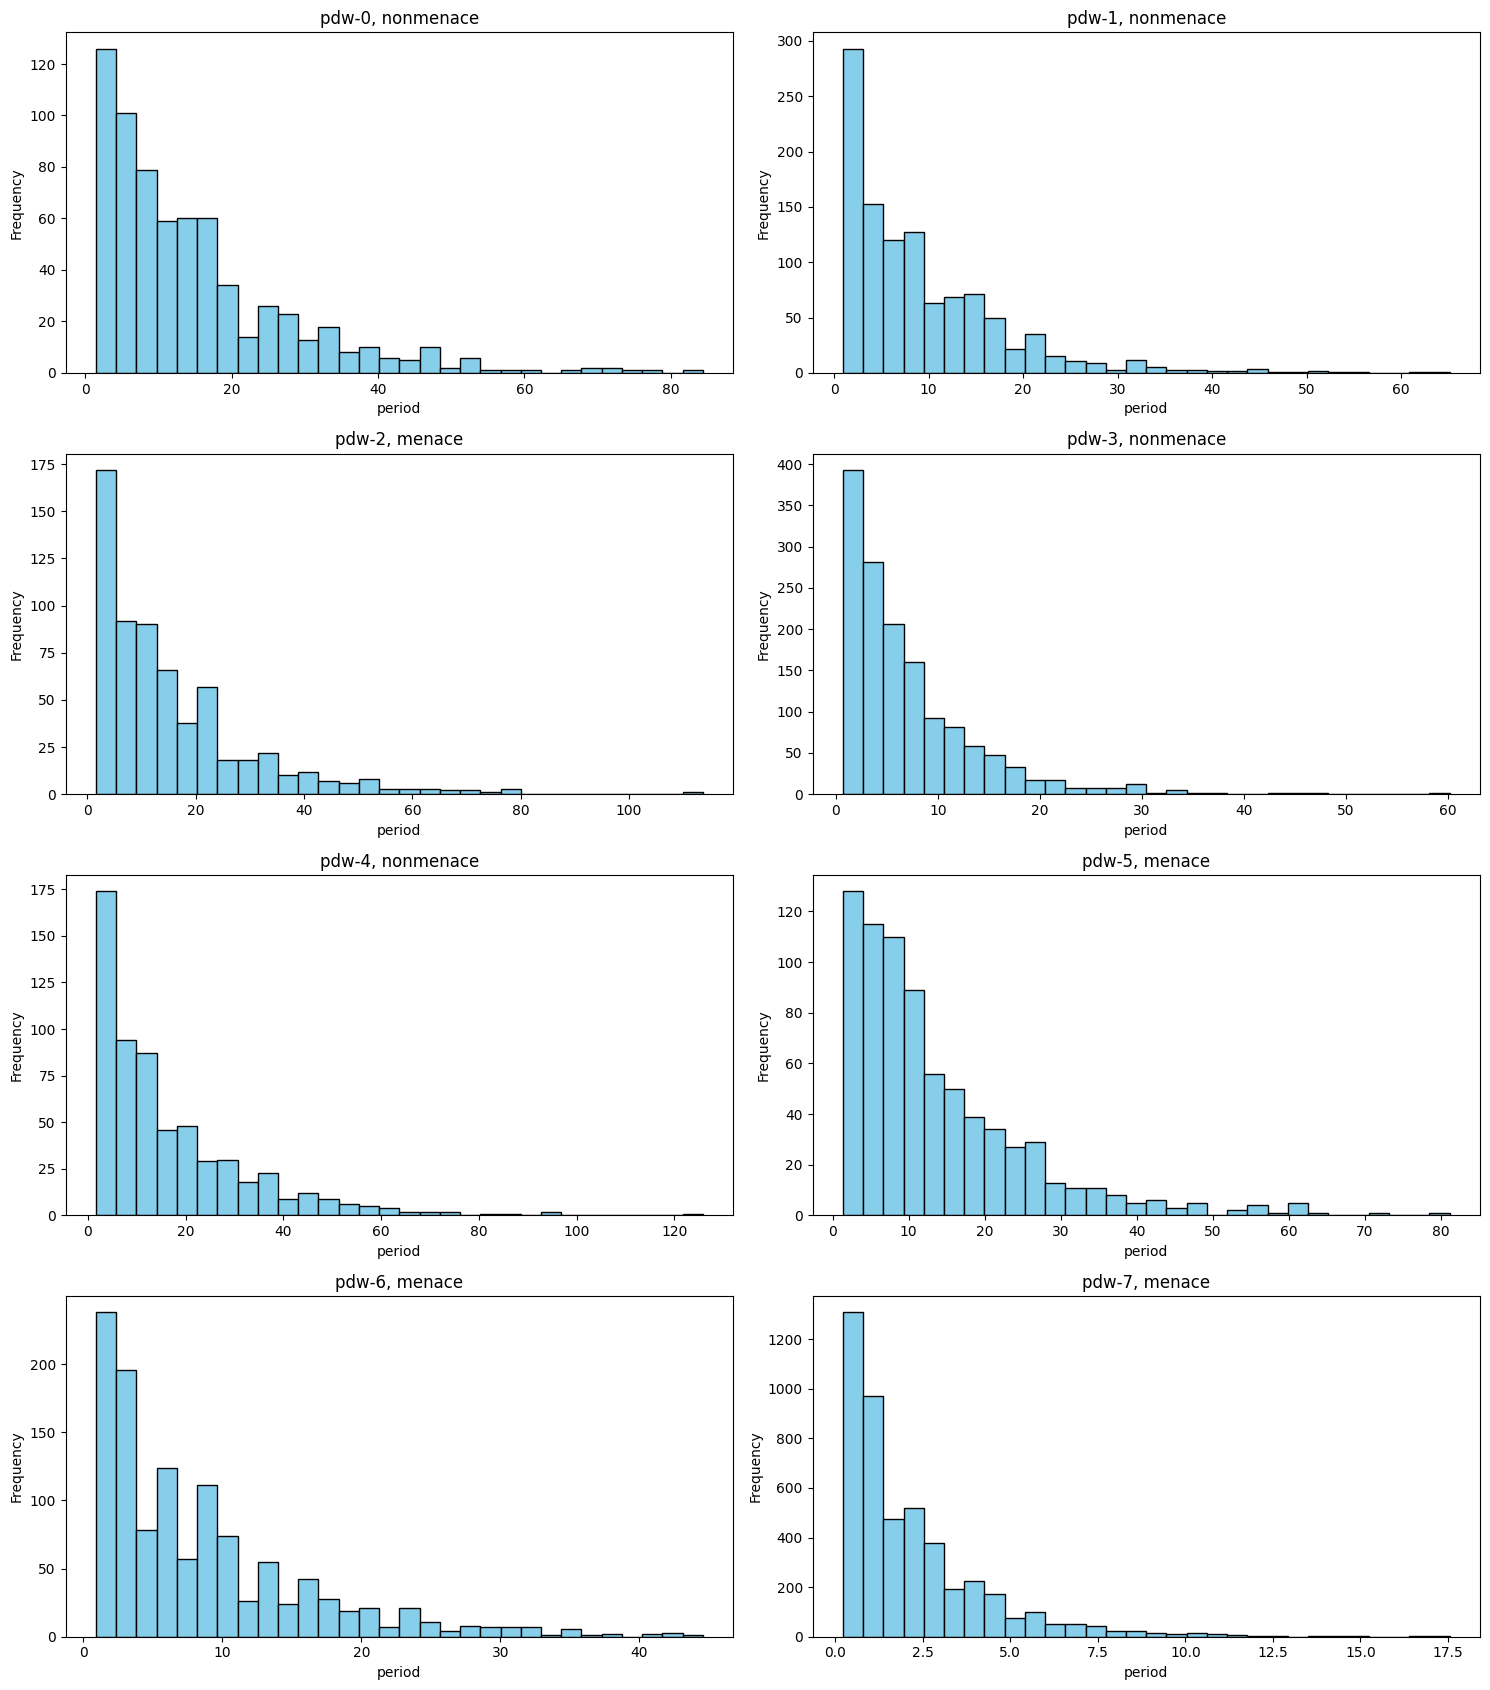

In [12]:
fig, ax= plt.subplots(4,2, figsize=(15, 17))
for i in range(8):
    label= dict_labels[f'pdw-{i}']
    pdws = np.load(f'./radars/train/pdw-{i}.npz')
    dates = pdws['date']
    diff= np.ediff1d(dates)
    r= i//2
    c= i%2
    ax[r,c].hist(diff, bins=30, color='skyblue', edgecolor='black')
    ax[r,c].set_title(f'pdw-{i}, {label}')
    ax[r,c].set_xlabel('period')
    ax[r,c].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Naïve Algorithm (logistic regression)

### Arrange the data
<div> we suppose that 1--> menace   and    0--> nonmeance</div>

In [13]:
train_path = './radars/train'
test_path = './radars/test'

with open('./radars/train_labels.json') as f:
    train_labels = json.load(f)

with open('./radars/test_labels.json') as f:
    test_labels = json.load(f)

# Constructing the train DataFrame
train_data = []
for i, file in enumerate(os.listdir(train_path)):
    pdws = np.load(os.path.join(train_path, f'pdw-{i}.npz'))
    pdw_data = {
        'id': f'pdw-{i}',
        'date': pdws['date'],
        'largeur': pdws['largeur'],
        'frequence': pdws['frequence'],
        'puissance': pdws['puissance'],
        'theta': pdws['theta'],
        'phi': pdws['phi'],
        'label': 1 if train_labels[f'pdw-{i}']== 'menace' else 0
    }
    train_data.append(pdw_data)

train_df = pd.DataFrame(train_data)

# Constructing the test DataFrame
test_data = []
for i, file in enumerate(os.listdir(test_path)):
    pdws = np.load(os.path.join(test_path, f'pdw-{i}.npz'))
    pdw_data = {
        'id': f'pdw-{i}',
        'date': pdws['date'],
        'largeur': pdws['largeur'],
        'frequence': pdws['frequence'],
        'puissance': pdws['puissance'],
        'theta': pdws['theta'],
        'phi': pdws['phi'],
        'label': 1 if test_labels[f'pdw-{i}']== 'menace' else 0
    }
    test_data.append(pdw_data)

test_df = pd.DataFrame(test_data)


In [14]:
train_df

,id,date,largeur,frequence,puissance,theta,phi,label
0,pdw-0,"[1.31, 24.985, 36.823, 66.42, 104.897, 122.655...","[0.291, 0.291, 0.293, 0.292, 0.291, 0.291, 0.2...","[2.2220113463017723, 2.1887378825919477, 2.204...","[-125.58248735699023, -133.03972100969634, -14...","[0.9578859532471261, 0.7757236420828455, 0.823...","[1.678935775441994, 1.8065992324090079, 1.3807...",0
1,pdw-1,"[3.72, 19.312, 24.814, 31.234, 40.408, 42.241,...","[0.138, 0.136, 0.138, 0.136, 0.138, 0.138, 0.1...","[3.011221070570557, 3.0262794017444095, 3.0064...","[-127.176799666022, -127.7514938922165, -127.2...","[2.7962717807754327, 3.100138202337863, 2.9741...","[1.5296932038533972, 1.7187292927487223, 1.709...",0
2,pdw-2,"[3.134, 26.803, 34.692, 39.427, 41.004, 44.160...","[0.201, 0.202, 0.203, 0.203, 0.202, 0.201, 0.2...","[0.9919904643038369, 0.9857211081518096, 0.986...","[-149.880060930416, -150.7680964513681, -150.6...","[-2.0412578355641227, -1.772373907923867, -1.7...","[1.6722396416013094, 1.6344171451080796, 1.600...",1
3,pdw-3,"[3.688, 14.634, 16.686, 18.056, 19.42300000000...","[0.068, 0.069, 0.069, 0.068, 0.068, 0.068, 0.0...","[1.6664240172021985, 1.6661103360176772, 1.662...","[-135.68775777002037, -134.50842919556754, -13...","[-2.621701006244045, -2.213762179939454, -2.70...","[1.4039557266900524, 1.488975965035762, 1.4761...",0
4,pdw-4,"[23.056, 51.203, 52.86, 59.483000000000004, 67...","[0.324, 0.324, 0.323, 0.325, 0.324, 0.325, 0.3...","[2.2078093931871146, 2.1930003703996603, 2.201...","[-172.60362010919195, -160.93505826531094, -16...","[2.274032092616462, 2.283569519382397, 2.15701...","[1.6134753329852611, 1.2039061221285539, 1.764...",0
...,...,...,...,...,...,...,...,...
1995,pdw-1995,"[19.457, 22.98, 30.909, 48.531, 52.054, 54.697...","[0.14300000000000002, 0.145, 0.144000000000000...","[1.2850955337422216, 1.1902637212972225, 1.195...","[-160.13320399511812, -164.76031529106373, -16...","[2.4678090398210197, 2.355151214391389, 2.4496...","[1.9522914801446203, 1.872165736643333, 1.3715...",1
1996,pdw-1996,"[3.9290000000000003, 7.847, 15.686, 16.663, 19...","[0.16, 0.161, 0.161, 0.161, 0.159, 0.159, 0.16...","[1.976714300141533, 1.7941903043434857, 1.8299...","[-131.34943780578416, -130.9531833230348, -131...","[2.266163545159358, 2.2617604731685117, 2.4740...","[1.3825684286473066, 1.605795469449473, 1.5279...",1
1997,pdw-1997,"[5.322, 7.026, 8.727, 8.97, 9.944, 10.429, 13....","[0.029, 0.027, 0.029, 0.029, 0.027, 0.027, 0.0...","[1.9213489264158359, 1.9124647925757723, 1.925...","[-127.94454697066773, -127.01740840617288, -12...","[-0.8608606907920762, -1.1109595030657935, -1....","[1.5708103500706487, 1.3960805606605136, 1.688...",1
1998,pdw-1998,"[20.609, 26.421, 28.166, 30.492, 34.559, 35.14...","[0.106, 0.106, 0.107, 0.106, 0.107, 0.108, 0.1...","[2.031979805572936, 2.036676303581711, 2.04573...","[-121.68668509549926, -123.07658247537033, -12...","[-1.0762623058886118, -0.8549202094920156, -0....","[1.3966699729566912, 1.4978168386646373, 1.571...",1


In [15]:
test_df

,id,date,largeur,frequence,puissance,theta,phi,label
0,pdw-0,"[23.78, 28.952, 35.162, 40.333, 62.063, 70.34,...","[0.249, 0.25, 0.249, 0.248, 0.249, 0.25, 0.249...","[1.257851290900774, 1.2610093911363802, 1.2622...","[-138.2164398933527, -127.01533236379927, -123...","[0.025498416430459248, -0.1715227848245161, 0....","[1.5842478052457605, 1.6725163692805622, 1.444...",1
1,pdw-1,"[11.63, 17.506, 29.263, 32.202, 46.898, 57.183...","[0.275, 0.275, 0.273, 0.273, 0.273, 0.275, 0.2...","[0.8906051506956049, 0.9939573749362038, 1.020...","[-97.2832478198323, -98.1766145572355, -98.814...","[-3.0382231134710316, -2.8494861423263496, -2....","[1.7378443194687776, 1.805356286967098, 1.7977...",1
2,pdw-2,"[7.237, 8.715, 13.144, 22.001, 26.432000000000...","[0.279, 0.28, 0.278, 0.278, 0.279, 0.278, 0.28...","[1.3325405245589292, 1.3371907160884844, 1.332...","[-141.53452000954488, -140.9613354254435, -141...","[-1.6591222701912707, -1.9225926149330628, -2....","[1.5317826808273285, 1.671787908362508, 1.6743...",0
3,pdw-3,"[17.385, 46.437, 59.512, 68.227, 78.398, 90.01...","[0.13, 0.129, 0.128, 0.129, 0.13, 0.128, 0.129...","[1.540237617346451, 1.5367485886875472, 1.5323...","[-117.97490135699024, -114.80852092087243, -11...","[1.4836218235176166, 1.5684588356902338, 1.331...","[1.394730294037142, 1.6879153556753024, 1.6241...",0
4,pdw-4,"[37.584, 49.775, 52.821, 54.346000000000004, 5...","[0.189, 0.19, 0.189, 0.19, 0.189, 0.188, 0.188...","[1.9320273708933182, 1.924995860181819, 1.9206...","[-117.10861466782144, -119.47269722606148, -11...","[-2.9912061514385937, -2.611886100707276, -2.7...","[1.5565843561684258, 1.7123051847596011, 1.509...",0
...,...,...,...,...,...,...,...,...
795,pdw-795,"[15.867, 18.149, 23.847, 37.529, 43.228, 75.14...","[0.115, 0.113, 0.113, 0.114, 0.114, 0.113, 0.1...","[1.3801602182266242, 1.3835312099837556, 1.385...","[-104.04536896344973, -104.3094473721899, -105...","[0.4063273339294079, 0.4453497041897904, 0.402...","[1.541663925204529, 1.5228296258817786, 1.7530...",0
796,pdw-796,"[20.805, 25.067, 38.559, 42.11, 42.822, 45.661...","[0.163, 0.163, 0.164, 0.163, 0.162, 0.163, 0.1...","[0.6978086490103046, 0.6985748901171743, 0.696...","[-140.84039866112386, -140.40527525915059, -13...","[-2.7962969347373505, -2.7989926297075036, -2....","[1.6219121653609336, 1.397681802713062, 1.5472...",1
797,pdw-797,"[2.354, 4.197, 4.657, 5.119, 5.578, 6.96, 8.34...","[0.105, 0.105, 0.10300000000000001, 0.10400000...","[0.5675097505750664, 0.5672510183745713, 0.564...","[-135.31056709173635, -142.78628308261688, -14...","[1.0818878111059702, 0.8351177204895907, 0.889...","[1.5065901367226104, 1.528952198684927, 1.2507...",1
798,pdw-798,"[3.086, 4.719, 16.548000000000002, 28.381, 34....","[0.07, 0.068, 0.069, 0.069, 0.069, 0.07, 0.07,...","[2.9920941852411835, 2.9959119182676357, 3.008...","[-111.24472170709028, -110.78157048766042, -11...","[0.3136336381054742, 0.1300763641872117, 0.356...","[1.7920365250385277, 1.691162264032767, 1.5089...",0


In [16]:
len(train_df)

2000

In [17]:
X_train = train_df['puissance'].apply(np.mean).values.reshape(-1, 1)  
y_train = train_df['label']

X_test = test_df['puissance'].apply(np.mean).values.reshape(-1, 1)  
y_test = test_df['label']

In [18]:
print(X_test.shape)
print(X_train.shape)

(800, 1)
(2000, 1)


In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred= model.predict(X_test)

accuracy= accuracy_score(y_test, y_pred)
print(f'the accuracy is: {accuracy}')

the accuracy is: 0.48375


<div>As we can see the obtained result is very bad so let's do some further preprocessing to the data and extract more features to see the results</div>

In [20]:
# extract some other features asside the mean from les puissances 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         2000 non-null   object
 1   date       2000 non-null   object
 2   largeur    2000 non-null   object
 3   frequence  2000 non-null   object
 4   puissance  2000 non-null   object
 5   theta      2000 non-null   object
 6   phi        2000 non-null   object
 7   label      2000 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 125.1+ KB


In [21]:
X_train = pd.DataFrame({
    'mean_puissance': train_df['puissance'].apply(np.mean),
    'variance_puissance': train_df['puissance'].apply(np.var),
    'max_puissance': train_df['puissance'].apply(np.max),
    'skewness_puissance': train_df['puissance'].apply(lambda x: pd.Series(x).skew()),
    'kurtosis_puissance' : train_df['puissance'].apply(lambda x: pd.Series(x).kurt()),
    'median_puissance' : train_df['puissance'].apply(np.median),
    'mean_largeur': train_df['largeur'].apply(np.mean),
    'variance_largeur': train_df['largeur'].apply(np.var),
    'max_largeur': train_df['largeur'].apply(np.max),
    'median_largeur' : train_df['largeur'].apply(np.median),
    'max_theta': train_df['theta'].apply(np.max),
    'variance_theta': train_df['theta'].apply(np.var),
    'mean_theta': train_df['theta'].apply(np.mean),
    'max_phi': train_df['phi'].apply(np.max),
    'variance_phi': train_df['phi'].apply(np.var),
    'mean_phi': train_df['phi'].apply(np.mean)
})
X_test = pd.DataFrame({
    'mean_puissance': test_df['puissance'].apply(np.mean),
    'variance_puissance': test_df['puissance'].apply(np.var),
    'max_puissance': test_df['puissance'].apply(np.max),
    'skewness_puissance': test_df['puissance'].apply(lambda x: pd.Series(x).skew()),
    'kurtosis_puissance' : test_df['puissance'].apply(lambda x: pd.Series(x).kurt()),
    'median_puissance' : test_df['puissance'].apply(np.median),
    'mean_largeur': test_df['largeur'].apply(np.mean),
    'variance_largeur': test_df['largeur'].apply(np.var),
    'max_largeur': test_df['largeur'].apply(np.max),
    'median_largeur' : test_df['largeur'].apply(np.median),
    'max_theta': test_df['theta'].apply(np.max),
    'variance_theta': test_df['theta'].apply(np.var),
    'mean_theta': test_df['theta'].apply(np.mean),
    'max_phi': test_df['phi'].apply(np.max),
    'variance_phi': test_df['phi'].apply(np.var),
    'mean_phi': test_df['phi'].apply(np.mean)
})

model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f'the accuracy is: {accuracy}')

the accuracy is: 0.67375


c:\Users\imane\MVA\Apprentissage profond et traitement du signal, introduction et applications industrielles\TP\TP2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Use other classifiers

we now test some other classifiers on our data

In [22]:
classifiers = [
    SVC(kernel="linear", C=0.025, random_state=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=1),
    DecisionTreeClassifier(max_depth=10, random_state=1),
    RandomForestClassifier(max_depth=10, random_state=1),
    MLPClassifier(alpha=1, max_iter=1000, random_state=1),
    AdaBoostClassifier(random_state=1),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

for model in classifiers:
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'the accuracy for moedl:  {model} is: {accuracy}')
    print(f'And the conf matrix is {conf_matrix} \n')
    

the accuracy for moedl:  SVC(C=0.025, kernel='linear', random_state=1) is: 0.66625
And the conf matrix is [[385  30]
 [237 148]] 

the accuracy for moedl:  GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1), random_state=1) is: 0.69875
And the conf matrix is [[309 106]
 [135 250]] 

the accuracy for moedl:  DecisionTreeClassifier(max_depth=10, random_state=1) is: 0.62875
And the conf matrix is [[250 165]
 [132 253]] 

the accuracy for moedl:  RandomForestClassifier(max_depth=10, random_state=1) is: 0.71125
And the conf matrix is [[328  87]
 [144 241]] 

the accuracy for moedl:  MLPClassifier(alpha=1, max_iter=1000, random_state=1) is: 0.57875
And the conf matrix is [[119 296]
 [ 41 344]] 

the accuracy for moedl:  AdaBoostClassifier(random_state=1) is: 0.69875
And the conf matrix is [[310 105]
 [136 249]] 

the accuracy for moedl:  GaussianNB() is: 0.6475
And the conf matrix is [[329  86]
 [196 189]] 

the accuracy for moedl:  QuadraticDiscriminantAnalysis() is: 0.6575
And the

c:\Users\imane\MVA\Apprentissage profond et traitement du signal, introduction et applications industrielles\TP\TP2\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


As we can see the best classifier is the random forest classifier

## Other attempts
we try to change the features and we see how they affect classification

Cross-validation scores: [0.86  0.845 0.83  0.86  0.875 0.84  0.81  0.87  0.855 0.835]
Mean cross-validation score: 0.8480000000000001
The accuracy for model RandomForestClassifier(max_depth=20, random_state=1) is: 0.83875
And the confusion matrix is [[384  31]
 [ 98 287]] 

Cross-validation scores: [0.815 0.85  0.84  0.86  0.88  0.82  0.845 0.865 0.86  0.805]
Mean cross-validation score: 0.8440000000000001
The accuracy for model AdaBoostClassifier(random_state=1) is: 0.8225
And the confusion matrix is [[355  60]
 [ 82 303]] 

Cross-validation scores: [0.825 0.81  0.845 0.84  0.835 0.78  0.835 0.82  0.835 0.83 ]
Mean cross-validation score: 0.8254999999999999
The accuracy for model DecisionTreeClassifier(max_depth=10, random_state=1) is: 0.81125
And the confusion matrix is [[368  47]
 [104 281]] 

Cross-validation scores: [0.805 0.76  0.725 0.785 0.76  0.755 0.775 0.755 0.8   0.77 ]
Mean cross-validation score: 0.7689999999999999
The accuracy for model SVC(C=0.025, kernel='linear', ran

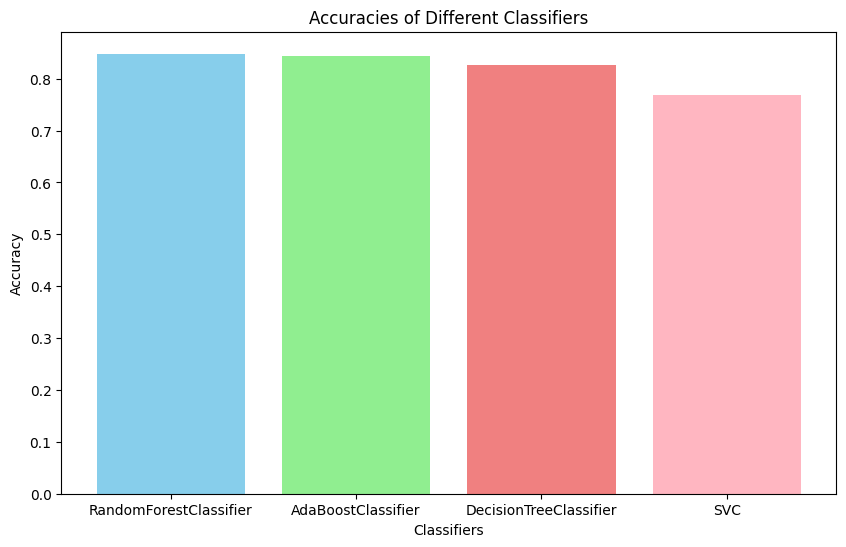

In [24]:
X_train = pd.DataFrame({
    'period': train_df["date"].apply(np.ediff1d).apply(hmean),
    'interquartile_range_puissance': train_df['puissance'].apply(iqr),
    'interquartile_range_largeur': train_df['largeur'].apply(iqr),
    'standard_deviation_theta': train_df['theta'].apply(np.std),
    'standard_deviation_phi': train_df['phi'].apply(np.std),
    'skewness_frequency': train_df['frequence'].apply(skew),
    'skewness_power_density': train_df['puissance'].apply(skew),
    'kurtosis_frequency': train_df['frequence'].apply(kurtosis),
    'kurtosis_power_density': train_df['puissance'].apply(kurtosis),
    'median_absolute_deviation_puissance': train_df['puissance'].apply(median_abs_deviation),
    'median_absolute_deviation_largeur': train_df['largeur'].apply(median_abs_deviation),
    'median_absolute_deviation_date': train_df['date'].apply(median_abs_deviation),
    'range_frequency': train_df['frequence'].apply(lambda x: np.max(x) - np.min(x)),
    'range_power_density': train_df['puissance'].apply(lambda x: np.max(x) - np.min(x)),


    'mean_distance_theta_phi': train_df.apply(lambda row: np.mean(np.abs(row['theta'] - row['phi'])), axis=1),
    'variation_puissance': train_df['puissance'].apply(variation),
    'variation_largeur': train_df['largeur'].apply(variation),
    'variation_theta': train_df['theta'].apply(variation),
    'variation_phi': train_df['phi'].apply(variation),
    'variation_date': train_df['date'].apply(variation),
    'variation_frequence': train_df['frequence'].apply(variation)
})

X_test = pd.DataFrame({
    'period': test_df["date"].apply(np.ediff1d).apply(hmean),
    'interquartile_range_puissance': test_df['puissance'].apply(iqr),
    'interquartile_range_largeur': test_df['largeur'].apply(iqr),
    'standard_deviation_theta': test_df['theta'].apply(np.std),
    'standard_deviation_phi': test_df['phi'].apply(np.std),
    'skewness_frequency': test_df['frequence'].apply(skew),
    'skewness_power_density': test_df['puissance'].apply(skew),
    'kurtosis_frequency': test_df['frequence'].apply(kurtosis),
    'kurtosis_power_density': test_df['puissance'].apply(kurtosis),
    'median_absolute_deviation_puissance': test_df['puissance'].apply(median_abs_deviation),
    'median_absolute_deviation_largeur': test_df['largeur'].apply(median_abs_deviation),
    'median_absolute_deviation_date': test_df['date'].apply(median_abs_deviation),
    'range_frequency': test_df['frequence'].apply(lambda x: np.max(x) - np.min(x)),
    'range_power_density': test_df['puissance'].apply(lambda x: np.max(x) - np.min(x)),
    'mean_distance_theta_phi': test_df.apply(lambda row: np.mean(np.abs(row['theta'] - row['phi'])), axis=1),
    'variation_puissance': test_df['puissance'].apply(variation),
    'variation_largeur': test_df['largeur'].apply(variation),
    'variation_theta': test_df['theta'].apply(variation),
    'variation_phi': test_df['phi'].apply(variation),
    'variation_date': test_df['date'].apply(variation),
    'variation_frequence': test_df['frequence'].apply(variation)
})

classifiers2 = [
    RandomForestClassifier(max_depth=20, random_state=1),
    AdaBoostClassifier(random_state=1),
    DecisionTreeClassifier(max_depth=10, random_state=1),
    SVC(kernel="linear", C=0.025, random_state=1),
]

k_folds= 10

accuracies = []
classifiers_names = []

for model in classifiers2:
    #perform crossvalidation
    scores= cross_val_score(model, X_train, y_train, cv= k_folds)
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {scores.mean()}")
    model.fit(X_train, y_train)
    y_pred= model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f'The accuracy for model {model} is: {accuracy}')
    print(f'And the confusion matrix is {conf_matrix} \n')
    accuracies.append(scores.mean())
    classifiers_names.append(str(model).split("(")[0])

plt.figure(figsize=(10, 6))
plt.bar(classifiers_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'lightpink'])
plt.title('Accuracies of Different Classifiers')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()